# Utilizando o Optuna como otimizador de hiperparâmetros de modelos de machine learning para a classificação de dados do Iris dataset

## requirements.txt

Crie um arquivo `requirements.txt` na raiz do projeto e cole os pacotes e versões requeridas listadas abaixo nesse arquivo. Em seguida instale as dependências em um ambiente virtual com o comando `pip install -r requirements.txt`.


```
lightgbm==3.0.0
matplotlib==3.2.2
pandas==1.3.5
scikit-learn==1.0.2
seaborn==0.11.2
optuna==3.0.4
optuna-dashboard==0.8.0
tensorflow==2.9.2
xgboost==0.90
```

In [1]:
! echo -e "lightgbm==3.0.0\nmatplotlib==3.2.2\npandas==1.3.5\nscikit-learn==1.0.2\nseaborn==0.11.2\noptuna==3.0.4\noptuna-dashboard==0.8.0\ntensorflow==2.9.2\nxgboost==0.90" > requirements.txt

In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 26.6 MB/s 
     |████████████████████████████████| 348 kB 62.8 MB/s 
     |████████████████████████████████| 2.5 MB 68.2 MB/s 
     |████████████████████████████████| 81 kB 12.4 MB/s 
     |████████████████████████████████| 210 kB 78.8 MB/s 
     |████████████████████████████████| 90 kB 12.2 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 147 kB 51.7 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 49.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=87f0413fbaa515c835b1570e3d0c00ddbe0280d234edbf60d06282d12db3b608
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-m

## Carregamento da base de dados

In [3]:
# Carregamento do dataset Iris no formato matriz do numpy a partir do sklearn
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()

# Criação do Iris DataFrame
df_iris_base = pd.DataFrame(data= iris.data, columns= iris.feature_names)
df_iris_base['species_numeric'] = iris.target
df_iris_base['species_categorical'] = df_iris_base['species_numeric'].map({
    0: 'setosa',
    1: 'versicolor',
    2: 'virginica'
})

df_iris_categorical_target = df_iris_base.copy().drop(columns=['species_numeric']).rename(columns={'species_categorical': 'species'})
df_iris_numeric_target = df_iris_base.copy().drop(columns=['species_categorical']).rename(columns={'species_numeric': 'species'})

df_iris = df_iris_categorical_target.copy()

## EDA - Análise Exploratória dos Dados

In [4]:
#@title Quantidade de dados não nulos por atributo do dataframe

df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
#@title Descrição estatística contendo métricas como média, mediana e desvio padrão para cada atributo do dataframe
df_iris.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000

In [6]:
#@title Quantidade de registros por espécie
df_iris['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

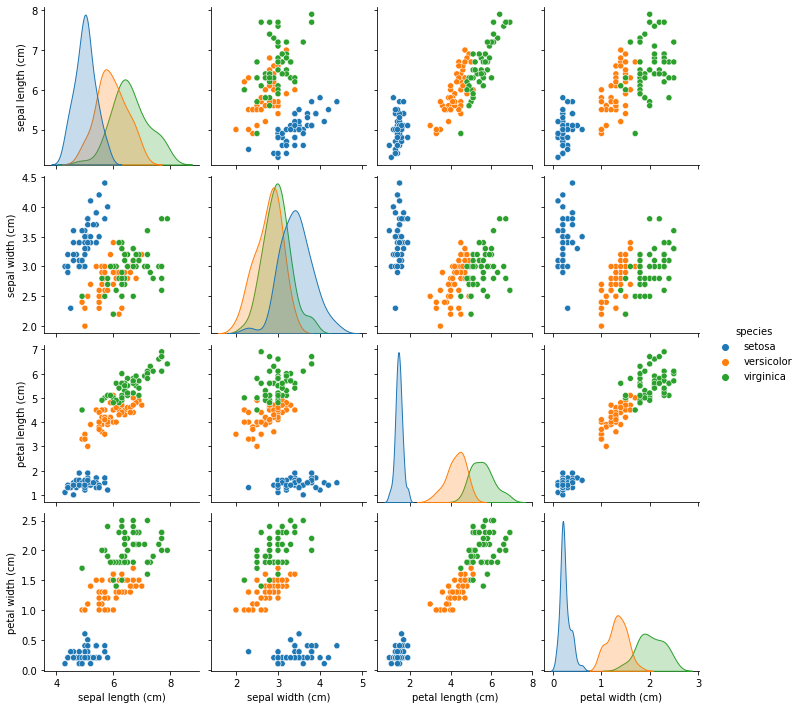

In [7]:
#@title Matriz de distribuição de dados
import seaborn as sns

sns.pairplot(df_iris, hue= 'species')

<ipython-input-8-6d6a13054db4>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_iris.corr(), dtype=np.bool))


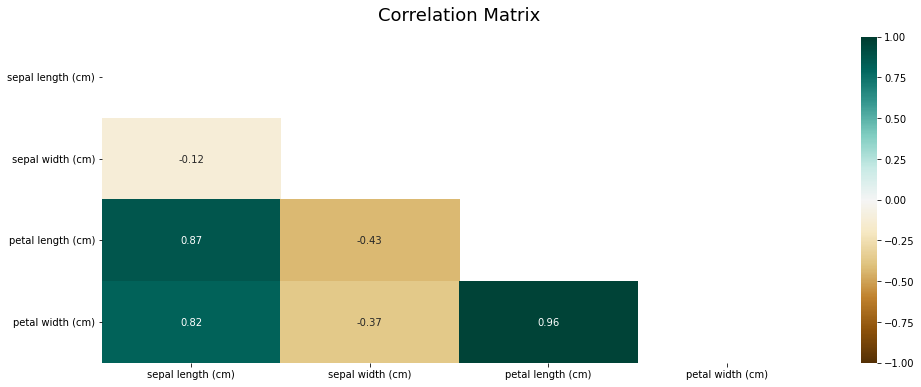

In [8]:
#@title Matriz de correlação dos dados
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_iris.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_iris.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=16);

## Hiperparametrização dos modelos de Machine Learning com o Optuna

O Optuna permite otimizar os hiperparâmetros a partir da minimização ou maximização de funções objetivo contendo apenas uma métrica de interesse no retorno da função, nesse caso a função objetivo é chamada de single objective. Ou funções objetivo contendo mais de uma métrica de interesse no retorno da função, nesse caso a função objetivo é chamada de multi objective.

In [9]:
#@title Funções compartilhadas para apresentação do output

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix 
) #, multilabel_confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None):
  cm = confusion_matrix(y_true, y_pred)
  # cm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
  ax = plt.axes()
  df_cm = cm
  sns.heatmap(cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
  ax.set_title('Confusion Matrix')
  plt.show()

def describe_results(y_true, y_pred, target_names=None, labels=None):
  accuracy = accuracy_score(y_true, y_pred)
  print('Accuracy: ', accuracy)

  print(classification_report(y_true, y_pred, target_names=target_names, labels=labels))

In [10]:
#@title Preparação dos dados utilizando a normalização StandardScaler e divisão do conjunto em treinamento e teste

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def get_train_test_split(df):
  X_columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  y_column = 'species'

  # Splitting the dataset into the Training set and Test set
  X = df[X_columns]
  y = df[y_column]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

  sc = StandardScaler()
  X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_columns)
  X_test = pd.DataFrame(sc.transform(X_test), columns=X_columns)

  return X_train, y_train, X_test, y_test, sc

X_train, y_train, X_test, y_test, sc = get_train_test_split(df_iris)

### Otimização dos hiperparâmetros utilizando a estrutura **single objective**


A estrutura **single objetive** busca otimizar apenas uma métrica de avaliação de desempenho dos modelos. 

No exemplo deste notebook, é implementada a classe `ClassifierOptimizerSingleObjective` que encapsula a utilização do optuna e o treinamento do modelo com melhor desempenho para a acurácia da tarefa de classificação do dataset iris.

In [11]:
#@title Definição do objeto ClassifierOptimizerSingleObjective que busca otimizar a acurácia

from typing import Union

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import xgboost as xgb



class ClassifierOptimizerSingleObjective:
    """
    Class responsible to train multiple models, optimizing the hyperparameters
    and return a best model performance.
    """

    def __init__(
        self,
        n_trials: int = 500,
        timeout: int = 600,
        n_jobs: int = -1,
        k_folds: int = 5,
        study_name: str = 'classifier_sigle_objective_study',
        db_storage: str = 'sqlite:///classifier_sigle_objective_study.db',
    ) -> None:
        self.n_trials = n_trials
        self.timeout = timeout
        self.n_jobs = n_jobs
        self.k_folds = k_folds
        self.study_name = study_name
        self.db_storage = db_storage
        self._study = self._study_load_or_create()
        self._best_model = None

    def _study_load_or_create(self):
      """Method responsible to load or create a optuna study."""
      
      study = optuna.create_study(
          study_name=self.study_name, 
          storage=self.db_storage, 
          load_if_exists=True,
          direction="maximize"
      )
      return study

    def get_study(self):
      """Method responsible to return the optuna study object."""
      return self._study

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Method responsible to return the fitted best model.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Fitted best model.
        """

        # Study optimize function
        self._study_optimizer(X, y)
        self._best_model = self._classifier_fit_best_model(X, y)
        return self._best_model

    def _study_optimizer(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Method responsible to start the classifier Optuna study and call the
        optimization to find the best ML model with the best hyperparameters.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Optuna study object.
        """
        
        # Wrap the objective inside a lambda and call objective inside it
        objective_wrap_func = lambda trial: self._objective(
            trial, X, y
        )

        # Invoke optimization of the objective function.
        self._study.optimize(
            objective_wrap_func,
            n_trials=self.n_trials,
            timeout=self.timeout,
            n_jobs=self.n_jobs,
        )
        return self

    def _objective(
        self,
        trial: optuna.Trial,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ) -> float:
        """
        Objective function responsible to maximaze the metrics scores to 
        diffirents ML models with differents hyperparameters configurations to 
        classify the Iris data. This method also applies a custom cross 
        validation.

        Arguments:
            trial -- Optuna trial object

            X -- X values

            y -- y target

        Returns:
            Mean accuracy score.
        """

        classifier_name = trial.suggest_categorical(
            "classifier",
            [
                "SVC", 
                "DecisionTreeClassifier",
                "RandomForest",
                "LightGBM",
            ],
        )
        if classifier_name == "SVC":
            classifier_obj = SVC(probability=True)
        elif classifier_name == "DecisionTreeClassifier":
            classifier_obj = DecisionTreeClassifier(
                max_depth=trial.suggest_int("dtc_max_depth", 2, 300),
                min_samples_split=trial.suggest_int(
                    "dtc_min_samples_split", 2, 65
                ),
                min_samples_leaf=trial.suggest_int(
                    "dtc_min_samples_leaf", 1, 16
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "dtc_min_weight_fraction_leaf", 0.0, 0.1
                ),
                max_features=trial.suggest_categorical(
                    "dtc_max_features", [None, "auto", "sqrt", "log2"]
                ),
                criterion=trial.suggest_categorical(
                    "dtc_criterion", ["gini", "entropy"]
                ),
                splitter=trial.suggest_categorical(
                    "dtc_splitter", ["best", "random"]
                ),
            )
        elif classifier_name == "RandomForest":
            classifier_obj = RandomForestClassifier(
                n_estimators=trial.suggest_int("rf_n_estimators", 2, 256),
                max_depth=trial.suggest_int("rf_max_depth", 2, 128),
                min_samples_split=trial.suggest_int(
                    "rf_min_samples_split", 2, 64
                ),
                min_samples_leaf=trial.suggest_int(
                    "rf_min_samples_leaf", 1, 16
                ),
                max_features=trial.suggest_categorical(
                "rf_max_features", ["sqrt", "log2", None]
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "rf_min_weight_fraction_leaf", 1e-5, 0.03, log=True
                ),
                max_samples=trial.suggest_float("rf_max_samples", 0.8, 1.0),
                criterion=trial.suggest_categorical(
                    "rf_criterion", ["gini", "entropy"]
                ),
            )
        elif classifier_name == "LightGBM":
            classifier_obj = lgb.LGBMClassifier(
                boosting_type=trial.suggest_categorical(
                    "lg_boosting_type", ["gbdt"]
                ),
                num_leaves=trial.suggest_int("lg_num_leaves", 16, 128),
                max_depth=trial.suggest_int("lg_max_depth", 2, 128),
                learning_rate=trial.suggest_float(
                    "lg_learning_rate", 5e-3, 2e-1
                ),
                n_estimators=trial.suggest_int("lg_n_estimators", 2, 256),
                min_child_samples=trial.suggest_int(
                    "lg_min_child_samples", 1, 32
                ),
                colsample_bytree=trial.suggest_float(
                    "lg_colsample_bytree", 0.8, 1.0
                ),
            )

        cv = self.k_folds
        scores = cross_val_score(
            classifier_obj,
            X,
            y.values.ravel(),
            cv=cv,
            scoring="accuracy",
            n_jobs=-1,
        )
        return np.mean(scores)

    def _classifier_fit_best_model(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> Union[
        SVC, DecisionTreeClassifier, RandomForestClassifier, lgb.LGBMClassifier
    ]:
        """
        Method responsible to train again the model with the best performance by
        passing the best hyperparameters as arguments to classify the iris data.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            The pre trained best model.
        """
        y = y.values.ravel()

        best_model_name = self._study.best_params["classifier"]
        best_params = self._study.best_params

        if best_model_name == "SVC":
            best_model = SVC(probability=True).fit(X, y)
        elif best_model_name == "DecisionTreeClassifier":
            best_model = DecisionTreeClassifier(
                max_depth=best_params["dtc_max_depth"],
                min_samples_split=best_params["dtc_min_samples_split"],
                min_samples_leaf=best_params["dtc_min_samples_leaf"],
                min_weight_fraction_leaf=best_params[
                    "dtc_min_weight_fraction_leaf"
                ],
                max_features=best_params["dtc_max_features"],
                criterion=best_params["dtc_criterion"],
                splitter=best_params["dtc_splitter"],
            )
        elif best_model_name == "RandomForest":
            best_model = RandomForestClassifier(
                n_estimators=best_params["rf_n_estimators"],
                max_depth=best_params["rf_max_depth"],
                min_samples_split=best_params["rf_min_samples_split"],
                min_samples_leaf=best_params["rf_min_samples_leaf"],
                max_features=best_params["rf_max_features"],
                min_weight_fraction_leaf=best_params[
                    "rf_min_weight_fraction_leaf"
                ],
                max_samples=best_params["rf_max_samples"],
                criterion=best_params["rf_criterion"],
            ).fit(X, y)
        elif best_model_name == "LightGBM":
            best_model = lgb.LGBMClassifier(
                boosting_type=best_params["lg_boosting_type"],
                num_leaves=best_params["lg_num_leaves"],
                max_depth=best_params["lg_max_depth"],
                learning_rate=best_params["lg_learning_rate"],
                n_estimators=best_params["lg_n_estimators"],
                min_child_samples=best_params["lg_min_child_samples"],
                colsample_bytree=best_params["lg_colsample_bytree"],
            ).fit(X, y)

        return best_model


In [12]:
#@title Execução da otimização dos hiperparâmetros com o objeto ClassifierOptimizerSingleObjective

classifier_optimizer_so = ClassifierOptimizerSingleObjective(
    n_trials=5,
    timeout=600,
    n_jobs=-1,
    k_folds=5,
)

study_so = classifier_optimizer_so.get_study()

print("# ----- Before fit model -----#")
print(study_so)
print('\n\nTrials to dataframe')#, study_so.trials_dataframe())
display(study_so.trials_dataframe())

best_model_so = classifier_optimizer_so.fit(X=X_train, y=y_train)

print("\n\n# ----- After fit model -----#")
print(study_so)
print("\n\nBest trial\n", study_so.best_trial)
print("\n\nBest params\n", study_so.best_params)
print("\n\nBest value\n", study_so.best_value)
print('\n\nTrials to dataframe')#, study_so.trials_dataframe())
display(study_so.trials_dataframe())

[I 2022-12-20 12:30:46,462] A new study created in RDB with name: classifier_sigle_objective_study


# ----- Before fit model -----#


Trials to dataframe


Empty DataFrame
Columns: []
Index: []

[I 2022-12-20 12:30:49,791] Trial 0 finished with value: 0.9561264822134387 and parameters: {'classifier': 'SVC'}. Best is trial 0 with value: 0.9561264822134387.
[I 2022-12-20 12:30:49,818] Trial 1 finished with value: 0.9561264822134387 and parameters: {'classifier': 'SVC'}. Best is trial 0 with value: 0.9561264822134387.
[I 2022-12-20 12:30:50,461] Trial 3 finished with value: 0.6964426877470355 and parameters: {'classifier': 'DecisionTreeClassifier', 'dtc_max_depth': 108, 'dtc_min_samples_split': 64, 'dtc_min_samples_leaf': 9, 'dtc_min_weight_fraction_leaf': 0.045990308250717205, 'dtc_max_features': 'log2', 'dtc_criterion': 'gini', 'dtc_splitter': 'best'}. Best is trial 0 with value: 0.9561264822134387.
[I 2022-12-20 12:30:53,098] Trial 4 finished with value: 0.9644268774703558 and parameters: {'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_num_leaves': 20, 'lg_max_depth': 106, 'lg_learning_rate': 0.07230405396228948, 'lg_n_estimators': 90, 'lg_min_child_samples': 5, 'lg



# ----- After fit model -----#


Best trial
 FrozenTrial(number=4, values=[0.9644268774703558], datetime_start=datetime.datetime(2022, 12, 20, 12, 30, 50, 476863), datetime_complete=datetime.datetime(2022, 12, 20, 12, 30, 53, 69687), params={'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_colsample_bytree': 0.9025360527829566, 'lg_learning_rate': 0.07230405396228948, 'lg_max_depth': 106, 'lg_min_child_samples': 5, 'lg_n_estimators': 90, 'lg_num_leaves': 20}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'DecisionTreeClassifier', 'RandomForest', 'LightGBM')), 'lg_boosting_type': CategoricalDistribution(choices=('gbdt',)), 'lg_colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.8, step=None), 'lg_learning_rate': FloatDistribution(high=0.2, log=False, low=0.005, step=None), 'lg_max_depth': IntDistribution(high=128, log=False, low=2, step=1), 'lg_min_child_samples': IntDistribution(high=32, log=False, low=1, step=1), 'lg_n_estimators': IntDist

number     value             datetime_start          datetime_complete  \
0       0  0.956126 2022-12-20 12:30:46.622640 2022-12-20 12:30:49.691297   
1       1  0.956126 2022-12-20 12:30:46.655814 2022-12-20 12:30:49.739399   
2       2  0.892490 2022-12-20 12:30:49.863092 2022-12-20 12:30:53.370657   
3       3  0.696443 2022-12-20 12:30:49.868084 2022-12-20 12:30:50.400683   
4       4  0.964427 2022-12-20 12:30:50.476863 2022-12-20 12:30:53.069687   

                duration       params_classifier params_dtc_criterion  \
0 0 days 00:00:03.068657                     SVC                  NaN   
1 0 days 00:00:03.083585                     SVC                  NaN   
2 0 days 00:00:03.507565            RandomForest                  NaN   
3 0 days 00:00:00.532599  DecisionTreeClassifier                 gini   
4 0 days 00:00:02.592824                LightGBM                  NaN   

   params_dtc_max_depth params_dtc_max_features  params_dtc_min_samples_leaf  \
0                   NaN                     NaN                          NaN   
1                   NaN                     NaN                          NaN   
2                   NaN                     NaN                          NaN   
3                 108.0                    log2                          9.0   
4                   NaN                     NaN                          NaN   

   ...  params_lg_num_leaves  params_rf_criterion params_rf_max_depth  \
0  ...                   NaN                  NaN                 NaN   
1  ...                   NaN                  NaN                 NaN   
2  ...                   NaN              entropy                79.0   
3  ...                   NaN                  NaN                 NaN   
4  ...                  20.0                  NaN                 NaN   

  params_rf_max_features  params_rf_max_samples  params_rf_min_samples_leaf  \
0                    NaN                    NaN                         NaN   
1                    NaN                    NaN                         NaN   
2                   sqrt               0.831624                        14.0   
3                    NaN                    NaN                         NaN   
4                    NaN                    NaN                         NaN   

   params_rf_min_samples_split  params_rf_min_weight_fraction_leaf  \
0                          NaN                                 NaN   
1                          NaN                                 NaN   
2                         40.0                            0.000156   
3                          NaN                                 NaN   
4                          NaN                                 NaN   

   params_rf_n_estimators     state  
0                     NaN  COMPLETE  
1                     NaN  COMPLETE  
2                   238.0  COMPLETE  
3                     NaN  COMPLETE  
4                     NaN  COMPLETE  

[5 rows x 29 columns]

Classes: ['setosa' 'versicolor' 'virginica']


y_true      y_pred  setosa_proba  versicolor_proba  virginica_proba
114   virginica   virginica      0.000144          0.000135         0.999721
62   versicolor  versicolor      0.000174          0.999577         0.000249
33       setosa      setosa      0.999829          0.000097         0.000074
107   virginica   virginica      0.000082          0.000170         0.999748
7        setosa      setosa      0.999862          0.000064         0.000074
100   virginica   virginica      0.000073          0.000068         0.999859
40       setosa      setosa      0.999862          0.000064         0.000074
86   versicolor  versicolor      0.000031          0.999918         0.000052
76   versicolor  versicolor      0.000060          0.999824         0.000116
71   versicolor  versicolor      0.000098          0.999778         0.000123
134   virginica   virginica      0.000777          0.001322         0.997901
51   versicolor  versicolor      0.000040          0.999891         0.000069
73   versicolor  versicolor      0.000117          0.999736         0.000147
54   versicolor  versicolor      0.000067          0.999444         0.000489
63   versicolor  versicolor      0.000117          0.999758         0.000125
37       setosa      setosa      0.999862          0.000064         0.000074
78   versicolor  versicolor      0.000147          0.998149         0.001704
90   versicolor  versicolor      0.000081          0.999833         0.000087
45       setosa      setosa      0.999859          0.000067         0.000074
16       setosa      setosa      0.999862          0.000064         0.000074
121   virginica   virginica      0.000385          0.004071         0.995545
66   versicolor  versicolor      0.000102          0.999626         0.000271
24       setosa      setosa      0.999862          0.000064         0.000074
8        setosa      setosa      0.999844          0.000083         0.000074
126   virginica   virginica      0.000315          0.003195         0.996491
22       setosa      setosa      0.999862          0.000064         0.000074
44       setosa      setosa      0.999843          0.000083         0.000074
97   versicolor  versicolor      0.000098          0.999797         0.000105
93   versicolor  versicolor      0.000110          0.999771         0.000119
26       setosa      setosa      0.999862          0.000064         0.000074
137   virginica   virginica      0.000063          0.000193         0.999744
84   versicolor  versicolor      0.000132          0.999519         0.000349
27       setosa      setosa      0.999862          0.000064         0.000074
127   virginica   virginica      0.001412          0.016864         0.981723
132   virginica   virginica      0.000066          0.000062         0.999872
59   versicolor  versicolor      0.000097          0.999799         0.000104
18       setosa      setosa      0.999831          0.000095         0.000074
83   versicolor   virginica      0.000070          0.000077         0.999853

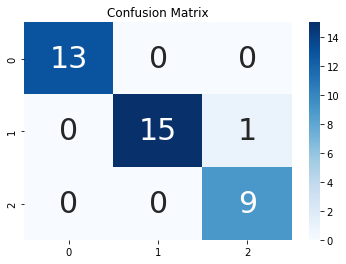

Accuracy:  0.9736842105263158
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



In [13]:
#@title Resultado da classificação para o conjunto de teste utilizando o best model da função single objective

classifier = best_model_so

print('Classes:', classifier.classes_[::])

# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Predict probabilities
probs_y = classifier.predict_proba(X_test)

y_true = y_test
df_y_true_pred = pd.DataFrame({
    'y_true': y_true, 
    'y_pred': y_pred, 
    'setosa_proba': probs_y[:,0], 
    'versicolor_proba': probs_y[:,1], 
    'virginica_proba': probs_y[:,2]
})

display(df_y_true_pred)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
describe_results(y_true=y_true, y_pred=y_pred, target_names=list(classifier.classes_))

### Otimização dos hiperparâmetros utilizando a estrutura **multi objective**


A estrutura **multi objetive** busca otimizar mais de uma métrica de avaliação de desempenho dos modelos.

No exemplo deste notebook, é implementada a classe `lassifierOptimizerMultiObjective` que encapsula a utilização do optuna e o treinamento do modelo com melhor desempenho para a acurácia, precision, recall e f1 score da tarefa de classificação do dataset iris.

In [14]:
#@title Definição do objeto ClassifierOptimizerMultiObjective que busca otimizar a acurácia, precision, recall e f1 score

from typing import Union

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import xgboost as xgb



class ClassifierOptimizerMultiObjective:
    """
    Class responsible to train multiple models, optimizing the hyperparameters
    and return a best model performance.
    """

    def __init__(
        self,
        n_trials: int = 500,
        timeout: int = 600,
        n_jobs: int = -1,
        k_folds: int = 5,
        study_name: str = 'classifier_muiltiple_objective_study',
        db_storage: str = 'sqlite:///classifier_muiltiple_objective_study.db',
    ) -> None:
        self.n_trials = n_trials
        self.timeout = timeout
        self.n_jobs = n_jobs
        self.k_folds = k_folds
        self.study_name = study_name
        self.db_storage = db_storage
        self._study = self._study_load_or_create()
        self._best_model = None

    def _study_load_or_create(self):
      """Method responsible to load or create a optuna study."""
      
      study = optuna.create_study(
          study_name=self.study_name, 
          storage=self.db_storage, 
          load_if_exists=True,
          directions=['maximize', 'maximize', 'maximize', 'maximize']
      )
      return study

    def get_study(self):
      """Method responsible to return the optuna study object."""
      return self._study

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Method responsible to return the fitted best model.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Fitted best model.
        """

        # Study optimize function
        self._study_optimizer(X, y)
        self._best_model = self._classifier_fit_best_model(X, y)
        return self._best_model
 
    def _study_optimizer(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Method responsible to start the classifier Optuna study and call the
        optimization to find the best ML model with the best hyperparameters.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Optuna study object.
        """

        # Wrap the objective inside a lambda and call objective inside it
        objective_wrap_func = lambda trial: self._objective(
            trial, X, y
        )

        # Invoke optimization of the objective function.
        self._study.optimize(
            objective_wrap_func,
            n_trials=self.n_trials,
            timeout=self.timeout,
            n_jobs=self.n_jobs,
        )
        return self

    def _objective(
        self,
        trial: optuna.Trial,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ) -> float:
        """
        Objective function responsible to maximaze the metrics scores to 
        diffirents ML models with differents hyperparameters configurations to 
        classify the Iris data. This method also applies a custom cross 
        validation.

        Arguments:
            trial -- Optuna trial object

            X -- X values

            y -- y target

        Returns:
            Mean accuracy score.
        """

        classifier_name = trial.suggest_categorical(
            "classifier",
            [
                "SVC", 
                "DecisionTreeClassifier",
                "RandomForest",
                "LightGBM",
            ],
        )
        if classifier_name == "SVC":
            classifier_obj = SVC(probability=True)
        elif classifier_name == "DecisionTreeClassifier":
            classifier_obj = DecisionTreeClassifier(
                max_depth=trial.suggest_int("dtc_max_depth", 2, 300),
                min_samples_split=trial.suggest_int(
                    "dtc_min_samples_split", 2, 65
                ),
                min_samples_leaf=trial.suggest_int(
                    "dtc_min_samples_leaf", 1, 16
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "dtc_min_weight_fraction_leaf", 0.0, 0.1
                ),
                max_features=trial.suggest_categorical(
                    "dtc_max_features", [None, "auto", "sqrt", "log2"]
                ),
                criterion=trial.suggest_categorical(
                    "dtc_criterion", ["gini", "entropy"]
                ),
                splitter=trial.suggest_categorical(
                    "dtc_splitter", ["best", "random"]
                ),
            )
        elif classifier_name == "RandomForest":
            classifier_obj = RandomForestClassifier(
                n_estimators=trial.suggest_int("rf_n_estimators", 2, 256),
                max_depth=trial.suggest_int("rf_max_depth", 2, 128),
                min_samples_split=trial.suggest_int(
                    "rf_min_samples_split", 2, 64
                ),
                min_samples_leaf=trial.suggest_int(
                    "rf_min_samples_leaf", 1, 16
                ),
                max_features=trial.suggest_categorical(
                "rf_max_features", ["sqrt", "log2", None]
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "rf_min_weight_fraction_leaf", 1e-5, 0.03, log=True
                ),
                max_samples=trial.suggest_float("rf_max_samples", 0.8, 1.0),
                criterion=trial.suggest_categorical(
                    "rf_criterion", ["gini", "entropy"]
                ),
            )
        elif classifier_name == "LightGBM":
            classifier_obj = lgb.LGBMClassifier(
                boosting_type=trial.suggest_categorical(
                    "lg_boosting_type", ["gbdt"]
                ),
                num_leaves=trial.suggest_int("lg_num_leaves", 16, 128),
                max_depth=trial.suggest_int("lg_max_depth", 2, 128),
                learning_rate=trial.suggest_float(
                    "lg_learning_rate", 5e-3, 2e-1
                ),
                n_estimators=trial.suggest_int("lg_n_estimators", 2, 256),
                min_child_samples=trial.suggest_int(
                    "lg_min_child_samples", 1, 32
                ),
                colsample_bytree=trial.suggest_float(
                    "lg_colsample_bytree", 0.8, 1.0
                ),
            )

        cv = self.k_folds
        scores = cross_validate(
            classifier_obj,
            X,
            y.values.ravel(),
            cv=cv,
            scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1,
        )
     
        accuracy = np.mean(scores['test_accuracy'])
        precision = np.mean(scores['test_precision_weighted'])
        recall = np.mean(scores['test_recall_weighted'])
        f1 = np.mean(scores['test_f1_weighted'])

        return accuracy, precision, recall, f1


    def _classifier_fit_best_model(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> Union[
        SVC, DecisionTreeClassifier, RandomForestClassifier, lgb.LGBMClassifier
    ]:
        """
        Method responsible to train again the model with the best performance by
        passing the best hyperparameters as arguments to classify the iris data.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            The pre trained best model.
        """
        y = y.values.ravel()
        best_params = self._study.best_trials[0].params
        best_model_name = best_params["classifier"]

        if best_model_name == "SVC":
            best_model = SVC(probability=True).fit(X, y)
        elif best_model_name == "DecisionTreeClassifier":
            best_model = DecisionTreeClassifier(
                max_depth=best_params["dtc_max_depth"],
                min_samples_split=best_params["dtc_min_samples_split"],
                min_samples_leaf=best_params["dtc_min_samples_leaf"],
                min_weight_fraction_leaf=best_params[
                    "dtc_min_weight_fraction_leaf"
                ],
                max_features=best_params["dtc_max_features"],
                criterion=best_params["dtc_criterion"],
                splitter=best_params["dtc_splitter"],
            )
        elif best_model_name == "RandomForest":
            best_model = RandomForestClassifier(
                n_estimators=best_params["rf_n_estimators"],
                max_depth=best_params["rf_max_depth"],
                min_samples_split=best_params["rf_min_samples_split"],
                min_samples_leaf=best_params["rf_min_samples_leaf"],
                max_features=best_params["rf_max_features"],
                min_weight_fraction_leaf=best_params[
                    "rf_min_weight_fraction_leaf"
                ],
                max_samples=best_params["rf_max_samples"],
                criterion=best_params["rf_criterion"],
            ).fit(X, y)
        elif best_model_name == "LightGBM":
            best_model = lgb.LGBMClassifier(
                boosting_type=best_params["lg_boosting_type"],
                num_leaves=best_params["lg_num_leaves"],
                max_depth=best_params["lg_max_depth"],
                learning_rate=best_params["lg_learning_rate"],
                n_estimators=best_params["lg_n_estimators"],
                min_child_samples=best_params["lg_min_child_samples"],
                colsample_bytree=best_params["lg_colsample_bytree"],
            ).fit(X, y)

        return best_model


In [15]:
#@title Execução da otimização dos hiperparâmetros com o objeto ClassifierOptimizerMultiObjective

classifier_optimizer_mo = ClassifierOptimizerMultiObjective(
    n_trials=5,
    timeout=600,
    n_jobs=-1,
    k_folds=5,
)

study_mo = classifier_optimizer_mo.get_study()

print("# ----- Before fit model -----#")
print(study_mo)
print('\n\nTrials to dataframe')#, study_mo.trials_dataframe())
display(study_mo.trials_dataframe())

best_model_mo = classifier_optimizer_mo.fit(X=X_train, y=y_train)

print("\n\n# ----- After fit model -----#")
print(study_mo)
print("\n\nBest trial\n", study_mo.best_trials)
print("\n\nBest params\n", study_mo.best_trials[0].params)
print("\n\nBest value\n", study_mo.best_trials[0].values)
print('\n\nTrials to dataframe')#, study_mo.trials_dataframe())
display(study_mo.trials_dataframe())


[I 2022-12-20 12:30:55,967] A new study created in RDB with name: classifier_muiltiple_objective_study


# ----- Before fit model -----#


Trials to dataframe


Empty DataFrame
Columns: []
Index: []

[I 2022-12-20 12:30:56,517] Trial 1 finished with values: [0.9561264822134387, 0.9660496267018006, 0.9561264822134387, 0.9568139107269543] and parameters: {'classifier': 'SVC'}. 
[I 2022-12-20 12:30:57,045] Trial 0 finished with values: [0.9553359683794467, 0.9584189723320158, 0.9553359683794467, 0.9551619796887115] and parameters: {'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_num_leaves': 42, 'lg_max_depth': 75, 'lg_learning_rate': 0.1746282706035428, 'lg_n_estimators': 245, 'lg_min_child_samples': 9, 'lg_colsample_bytree': 0.9196097262757568}. 
[I 2022-12-20 12:30:57,145] Trial 2 finished with values: [0.7422924901185771, 0.6055582822974127, 0.7422924901185771, 0.6546594468333599] and parameters: {'classifier': 'DecisionTreeClassifier', 'dtc_max_depth': 125, 'dtc_min_samples_split': 3, 'dtc_min_samples_leaf': 15, 'dtc_min_weight_fraction_leaf': 0.003073997579873167, 'dtc_max_features': 'sqrt', 'dtc_criterion': 'gini', 'dtc_splitter': 'random'}. 
[I 2022-12-20 12:30:59,07



# ----- After fit model -----#


Best trial
 [FrozenTrial(number=3, values=[0.9644268774703558, 0.9685199824330258, 0.9644268774703558, 0.9641706181091146], datetime_start=datetime.datetime(2022, 12, 20, 12, 30, 57, 80959), datetime_complete=datetime.datetime(2022, 12, 20, 12, 30, 59, 54786), params={'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_num_leaves': 66, 'lg_max_depth': 95, 'lg_learning_rate': 0.10554762885373126, 'lg_n_estimators': 228, 'lg_min_child_samples': 13, 'lg_colsample_bytree': 0.9722443963011839}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'DecisionTreeClassifier', 'RandomForest', 'LightGBM')), 'lg_boosting_type': CategoricalDistribution(choices=('gbdt',)), 'lg_num_leaves': IntDistribution(high=128, log=False, low=16, step=1), 'lg_max_depth': IntDistribution(high=128, log=False, low=2, step=1), 'lg_learning_rate': FloatDistribution(high=0.2, log=False, low=0.005, step=None), 'lg_n_estimators': IntDistribution(high=256, log=Fals

number  values_0  values_1  values_2  values_3             datetime_start  \
0       0  0.955336  0.958419  0.955336  0.955162 2022-12-20 12:30:56.022603   
1       1  0.956126  0.966050  0.956126  0.956814 2022-12-20 12:30:56.120799   
2       2  0.742292  0.605558  0.742292  0.654659 2022-12-20 12:30:56.547477   
3       3  0.964427  0.968520  0.964427  0.964171 2022-12-20 12:30:57.080959   
4       4  0.946245  0.949833  0.946245  0.945824 2022-12-20 12:30:57.248904   

           datetime_complete               duration       params_classifier  \
0 2022-12-20 12:30:57.013997 0 days 00:00:00.991394                LightGBM   
1 2022-12-20 12:30:56.395761 0 days 00:00:00.274962                     SVC   
2 2022-12-20 12:30:57.117093 0 days 00:00:00.569616  DecisionTreeClassifier   
3 2022-12-20 12:30:59.054786 0 days 00:00:01.973827                LightGBM   
4 2022-12-20 12:30:59.326684 0 days 00:00:02.077780            RandomForest   

  params_dtc_criterion  ...  params_rf_criterion params_rf_max_depth  \
0                  NaN  ...                  NaN                 NaN   
1                  NaN  ...                  NaN                 NaN   
2                 gini  ...                  NaN                 NaN   
3                  NaN  ...                  NaN                 NaN   
4                  NaN  ...              entropy                33.0   

   params_rf_max_features  params_rf_max_samples  params_rf_min_samples_leaf  \
0                     NaN                    NaN                         NaN   
1                     NaN                    NaN                         NaN   
2                     NaN                    NaN                         NaN   
3                     NaN                    NaN                         NaN   
4                     NaN                0.90974                         1.0   

  params_rf_min_samples_split params_rf_min_weight_fraction_leaf  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         NaN                                NaN   
3                         NaN                                NaN   
4                        34.0                           0.028086   

   params_rf_n_estimators  system_attrs_nsga2:generation     state  
0                     NaN                              0  COMPLETE  
1                     NaN                              0  COMPLETE  
2                     NaN                              0  COMPLETE  
3                     NaN                              0  COMPLETE  
4                   212.0                              0  COMPLETE  

[5 rows x 33 columns]

Classes: ['setosa' 'versicolor' 'virginica']


y_true      y_pred  setosa_proba  versicolor_proba  virginica_proba
114   virginica   virginica  1.191210e-07      6.675475e-08     9.999998e-01
62   versicolor  versicolor  3.468412e-05      9.979411e-01     2.024246e-03
33       setosa      setosa  9.999758e-01      2.422337e-05     2.010382e-08
107   virginica   virginica  2.656785e-07      3.308694e-06     9.999964e-01
7        setosa      setosa  9.999939e-01      6.062227e-06     2.017701e-08
100   virginica   virginica  6.435729e-08      1.347321e-07     9.999998e-01
40       setosa      setosa  9.999939e-01      6.041953e-06     2.011436e-08
86   versicolor  versicolor  3.673207e-07      9.999996e-01     4.959097e-08
76   versicolor  versicolor  3.232693e-07      9.999993e-01     3.454848e-07
71   versicolor  versicolor  3.135592e-07      9.999996e-01     7.620957e-08
134   virginica   virginica  1.936873e-06      1.517538e-05     9.999829e-01
51   versicolor  versicolor  4.830832e-07      9.999994e-01     6.766941e-08
73   versicolor  versicolor  4.924465e-07      9.999993e-01     2.135999e-07
54   versicolor  versicolor  5.903161e-07      9.999990e-01     4.053308e-07
63   versicolor  versicolor  2.510509e-07      9.999997e-01     8.791067e-08
37       setosa      setosa  9.999962e-01      3.738893e-06     3.335205e-08
78   versicolor  versicolor  2.657938e-05      9.981548e-01     1.818575e-03
90   versicolor  versicolor  2.706487e-06      9.999954e-01     1.857991e-06
45       setosa      setosa  9.999958e-01      3.384788e-06     8.306123e-07
16       setosa      setosa  9.999940e-01      6.022371e-06     2.010084e-08
121   virginica   virginica  1.636846e-05      3.122639e-04     9.996714e-01
66   versicolor  versicolor  9.710373e-06      9.999769e-01     1.339660e-05
24       setosa      setosa  9.999957e-01      4.240246e-06     3.322705e-08
8        setosa      setosa  9.999922e-01      6.994851e-06     7.807014e-07
126   virginica   virginica  1.795631e-04      2.754237e-03     9.970662e-01
22       setosa      setosa  9.999962e-01      3.738686e-06     3.335020e-08
44       setosa      setosa  9.999931e-01      6.835708e-06     1.998789e-08
97   versicolor  versicolor  1.640892e-07      9.999998e-01     2.937471e-08
93   versicolor  versicolor  8.183009e-06      9.999824e-01     9.378748e-06
26       setosa      setosa  9.999939e-01      6.062227e-06     2.017258e-08
137   virginica   virginica  1.580323e-07      2.433780e-07     9.999996e-01
84   versicolor  versicolor  3.737520e-05      9.999111e-01     5.156756e-05
27       setosa      setosa  9.999940e-01      6.027145e-06     2.011852e-08
127   virginica   virginica  5.957660e-04      2.516562e-01     7.477480e-01
132   virginica   virginica  2.912121e-08      2.844160e-09     1.000000e+00
59   versicolor  versicolor  9.261454e-06      9.999853e-01     5.420528e-06
18       setosa      setosa  9.999673e-01      3.269992e-05     2.203451e-08
83   versicolor   virginica  2.734776e-07      1.286009e-07     9.999996e-01

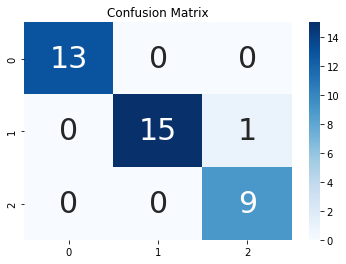

Accuracy:  0.9736842105263158
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



In [16]:
#@title Resultado da classificação para o conjunto de teste utilizando o best model da função multi objective

classifier = best_model_mo

print('Classes:', classifier.classes_[::])

# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Predict probabilities
probs_y = classifier.predict_proba(X_test)

y_true = y_test
df_y_true_pred = pd.DataFrame({
    'y_true': y_true, 
    'y_pred': y_pred, 
    'setosa_proba': probs_y[:,0], 
    'versicolor_proba': probs_y[:,1], 
    'virginica_proba': probs_y[:,2]
})

display(df_y_true_pred)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
describe_results(y_true=y_true, y_pred=y_pred, target_names=list(classifier.classes_))

## Visão geral dos recursos de visualização de dados do optuna

In [17]:
#@title Histórico da otimização da função objetivo
#@markdown Visualização do estudo single objective

optuna.visualization.plot_optimization_history(study_so)

In [18]:
#@title Dashboard do Optuna

# Executar na máquina local

# ! optuna-dashboard sqlite:///db.sqlite3 --port 8888